<a href="https://colab.research.google.com/github/aim97/Neural-networks/blob/master/Tensorflow/FunctionalAPI-enenrgy%2Befficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Functional API

Tensorflow adds more flexibility of defining the model using its functional API.

If your model is simply staking layers on top of one another, you only need to use `Sequential` Model, which will do the job for you. However if your code is more complicated taking different paths, and then rejoining, or having multiple different outputs, the usual sequential model wouldn't cut it and you would need a more flexible way to define your model.  

That's where the functional API comes for the rescue, it allows you to connect layers manually rather than having Sequential connect them for you, which allows you to connect your neural network in all sorts of ways.  

In order to build such model, Tensorflow requires you to provide 2 Things:

1. The model input(s).
2. The model output(s).

and provide them to `Model` class constructor, then from this point forward everything is like how it's done with Sequential.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
import numpy as np

What you need to understand is mainly how to connect layer with the functional API.  
```python
layer2_output = LayerConstructor( ...layer_parameters ) (layer1_output)
```

You form a connection better two layers in this way.

In [3]:
xs = Input((8,), name='model_input')
x = Dense(128, activation='relu', name='first')(xs)
x = Dense(128, activation='relu', name='second')(x)

y1 = Dense(1, name='y1_output')(x);
y2_path = Dense(64, activation='relu', name='another_path')(x)

y2 = Dense(1, name='y2_output')(y2_path)

In [4]:
model = tf.keras.Model(inputs=[xs], outputs=[y1, y2])  # when you have multiple output specifiy them all
# notice the names of the layers displayed in the summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
first (Dense)                   (None, 128)          1152        model_input[0][0]                
__________________________________________________________________________________________________
second (Dense)                  (None, 128)          16512       first[0][0]                      
__________________________________________________________________________________________________
another_path (Dense)            (None, 64)           8256        second[0][0]                     
______________________________________________________________________________________________

Note: with Tensorflow functional API, when you have multiple outputs, giving the output layer a name is important, actually it's a good practice to give each layer a unique (it has to be unique) name to identify it.  

1. It makes it easier to understand the model summary and model graph.
2. Multiple parts of tensorflow API use those names, for instance, in our case we want to define different loss and metrics of performance for each output we have, we provide a dictionary with the output layers **names** as keys.

```python
model.compile(
    optimizer=optimizer,
    loss={
        'y1_output': 'mse', 
        'y2_output': 'mse'
    },
    metrics={
        'y1_output': tf.keras.metrics.RootMeanSquaredError(),
        'y2_output': tf.keras.metrics.RootMeanSquaredError()
    }
)
```

You can also use a list to do the job which will depend on the order the outputs appear in the outputs list provided to the model constructor, but using a dictionary provides higher readability.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=[
        'mse', 
        'mse'
    ],
    metrics=[
        [tf.keras.metrics.RootMeanSquaredError()],
        [tf.keras.metrics.RootMeanSquaredError()]
    ]
)

We use sklearn `train_test_split` to split our dataset with a given ratio.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
# read the energy + efficiency data set from its URL
dataset = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx');
# suffule the dataset, then reset the index column since we don't want it suffuled as well.
dataset = dataset.sample(frac=1).reset_index(drop=True)

## Some Cleanup

Aside from splitting the dataset into training and testing sets, we also need to split it into input and output, which is done by the `format_output` helper function.

In [8]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


In [9]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(dataset, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [ ]:
# Train the model for 500 epochs
history = model.fit(
    norm_train_X, 
    np.array(train_Y).T,
    epochs=500, 
    batch_size=10, 
    validation_data=(norm_test_X, test_Y)
)

In [11]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 6.0626 - y1_output_loss: 2.9252 - y2_output_loss: 3.1374 - y1_output_root_mean_squared_error: 1.7103 - y2_output_root_mean_squared_error: 1.7713
Loss = 6.062577724456787, Y1_loss = 2.925175189971924, Y1_mse = 1.710314393043518, Y2_loss = 3.1374025344848633, Y2_mse = 1.7712714672088623


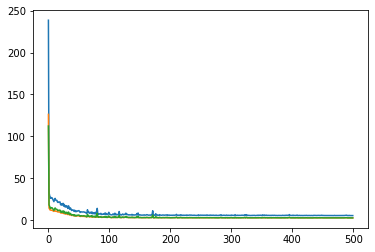

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss']);
plt.plot(history.history['y1_output_loss']);
plt.plot(history.history['y2_output_loss']);

In [14]:
print(history.history.keys())

dict_keys(['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_root_mean_squared_error', 'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_root_mean_squared_error', 'val_y2_output_root_mean_squared_error'])
